In [8]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score


In [39]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import load_model
import h5py
from tensorflow.keras import __version__ as keras_version
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Lambda, Cropping2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalMaxPooling2D

In [11]:
import os
import csv
import cv2
import sys
import collections
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder, LabelBinarizer

import xml.etree.ElementTree as ET

In [12]:
def get_filepaths(basepath, remove_ext=False):
    files = []
    filenames = []
    for filename in os.listdir(basepath):
#         print("filename =", filename)
        if remove_ext is True:
            file_name, file_ext = filename.split(".")
#             print("file_name =", file_name)
#             print("file_ext =", file_ext)
            filepath = os.path.join(basepath, file_name)
            files.append(filepath)
            filenames.append(file_name)
        else:
            filepath = os.path.join(basepath, filename)
            files.append(filepath)
            filenames.append(filename)
    return files, filenames
    
# TODO: Move above code into this function
def get_filepaths_videonum_dirs(basepath):
    videonum_frame_filepaths = []
    videonum_frame_filenames = []
    # loop each video number dir getting each frame filepath per video
    for videonum_dir in os.listdir(basepath):
        videonum_dirpath = os.path.join(basepath, videonum_dir)
        videonum_dirfilepaths, videonum_dirfilenames = get_filepaths(videonum_dirpath, remove_ext=True)
        videonum_frame_filepaths.extend(videonum_dirfilepaths)
        videonum_frame_filenames.extend(videonum_dirfilenames)
    return videonum_frame_filepaths, videonum_frame_filenames
    
def get_filepaths_videonum_dirs_xy(X_basepath, y_basepath):
    videonum_X_filepaths = []
    videonum_X_filenames = []
    videonum_y_filepaths = []
    videonum_y_filenames = []
    for videonum_X_dir, videonum_y_dir in zip(os.listdir(X_basepath), os.listdir(y_basepath)):
        videonum_X_dirpath = os.path.join(X_basepath, videonum_X_dir)
        videonum_y_dirpath = os.path.join(y_basepath, videonum_y_dir)
        videonum_y_dirfilepaths_tmp = []
        videonum_y_dirfilenames_tmp = []
        videonum_X_dirfilepaths, videonum_X_dirfilenames = get_filepaths(videonum_X_dirpath, remove_ext=True)
        videonum_y_dirfilepaths, videonum_y_dirfilenames = get_filepaths(videonum_y_dirpath, remove_ext=True)
#         print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#         print("len(videonum_y_dirfilenames) =", len(videonum_y_dirfilenames))
        if len(videonum_X_dirfilenames) != len(videonum_y_dirfilenames):
            for y_i in range(len(videonum_y_dirfilenames)):
                if videonum_y_dirfilenames[y_i] in videonum_X_dirfilenames:
#                     print("videonum_y_dirfilenames[y_i] =", videonum_y_dirfilenames[y_i])
#                     print("is in videonum_X_dirfilenames = ", videonum_X_dirfilenames)
                    videonum_y_dirfilenames_tmp.append(videonum_y_dirfilenames[y_i] + ".xml")
                    videonum_y_dirfilepaths_tmp.append(videonum_y_dirfilepaths[y_i] + ".xml")
            videonum_y_filepaths.extend(videonum_y_dirfilepaths_tmp)
            videonum_y_filenames.extend(videonum_y_dirfilenames_tmp)
#             print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#             print("len(videonum_y_dirfilenames_tmp) =", len(videonum_y_dirfilenames_tmp))
        else:
            videonum_y_dirfilepaths = [filepath + ".xml" for filepath in videonum_y_dirfilepaths]
            videonum_y_dirfilenames = [filename + ".xml" for filename in videonum_y_dirfilenames]
            videonum_y_filepaths.extend(videonum_y_dirfilepaths)
            videonum_y_filenames.extend(videonum_y_dirfilenames)
#             print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#             print("len(videonum_y_dirfilenames) =", len(videonum_y_dirfilenames))
        videonum_X_dirfilepaths = [filepath + ".jpg" for filepath in videonum_X_dirfilepaths]
        videonum_X_dirfilenames = [filename + ".jpg" for filename in videonum_X_dirfilenames]
        videonum_X_filepaths.extend(videonum_X_dirfilepaths)
        videonum_X_filenames.extend(videonum_X_dirfilenames)
    return videonum_X_filepaths, videonum_X_filenames, videonum_y_filepaths, videonum_y_filenames
    
def read_img(img_path):
    # (height, width, 3)
    image = cv2.imread(img_path)
    return image

def get_xml_label_names(xml_files):
    label_names = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_polyp_name = train_y_object.find("name").text
        else:
            train_y_polyp_name = "Not Specified"
        label_names.append(train_y_polyp_name)
    return label_names

def get_xml_boundboxes(xml_files):
    bound_boxes = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_bndbox = train_y_object.find("bndbox")
            train_y_bndbox_xmin = train_y_bndbox.find("xmin").text
            train_y_bndbox_ymin = train_y_bndbox.find("ymin").text
            train_y_bndbox_xmax = train_y_bndbox.find("xmax").text
            train_y_bndbox_ymax = train_y_bndbox.find("ymax").text
            bound_box_tuple = (train_y_bndbox_xmin, train_y_bndbox_ymin, train_y_bndbox_xmax, train_y_bndbox_ymax)
        else:
            bound_box_tuple = False
        bound_boxes.append(
            bound_box_tuple
        )
    return bound_boxes

# normalizes image pixel values betwen -0.5 and 0.5
def normalize_images(images):
    norm_images = []
    for image in tqdm(images):
        norm_img = (image/255.0) - 0.5
        norm_images.append(norm_img)
    return norm_images

def normalize_image(image):
    norm_img = (image/255.0) - 0.5
    return norm_img

def resize_image(image, size):
    resized_image = cv2.resize(image, (size, size))
    return resize_image
    
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_images(image_group, size):
    images = []
    for image_path in tqdm(image_group):
        image = read_img(image_path)
        resized_img = cv2.resize(image, (size, size))
        images.append(resized_img)
    return images

def remove_non_labeled_polyps(images, polyp_names):
    cln_X_img = []
    cln_y_polyp_names = []
    for image, label in zip(images, polyp_names):
        if label != "Not Specified":
            cln_X_img.append(image)
            cln_y_polyp_names.append(label)
            
    return cln_X_img, cln_y_polyp_names

def create_image_label_groups(image_paths, image_labels, batch_size=32):
    # Divide image paths and image labels into groups of BATCH_SIZE
    image_groups = list()
    label_groups = list()
    
    for idx in range(0, len(image_paths), batch_size):
        image_batch = list()
        for index in range(idx, idx + batch_size):
            image_batch.append(image_paths[index % len(image_paths)])
        image_groups.append(image_batch)
            
    for idx in range(0, len(image_labels), batch_size):
        for index in range(idx, idx + batch_size):
            label_groups.append(image_labels[index % len(image_labels)])
    
    return image_groups, label_groups
    
def create_image_batch(image_group):
    # get the max image shape from the batch of images
    max_shape = tuple()
    image_shapes = list()
    
    for channel in range(3):
        for image in image_group:
            image_shapes.append(image.shape[channel])
        
def change_extension(img_file, file_type):
    p = Path(img_file)
    return p.rename(p.with_suffix(file_type))
    
# loads image from filepath using opencv
def get_image(basepath, filepath):
    # read images
    source_path = filepath
    # extract filename from filepath using split and check platform
    if sys.platform == 'win32':
        filename = source_path.split("\\")[-1]
    elif sys.platform == 'linux' or sys.platform == 'darwin':
        filename = source_path.split("/")[-1]
    # add filename to end of path to PolypSet dir, so platform isn't an issue
    img_path_on_fs = basepath + filename
    # load image using opencv
    image = cv2.imread(img_path_on_fs)
    return image


def plot_sample(X, y, index):
    plt.figure(figsize = (30,4))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

In [9]:
sm.set_framework('tf.keras')

## Load Training Set

In [13]:
train_y_basepath = "PolypsSet/train2019/Annotation"
file_type = ".xml"
train_y_filepaths, train_y_filenames = get_filepaths(train_y_basepath, file_type)

In [14]:
train_X_basepath = "PolypsSet/train2019/Image"
file_type = ".jpg"
train_X_filepaths, train_X_filenames = get_filepaths(train_X_basepath, file_type)

In [15]:
train_y_polyp_names = get_xml_label_names(train_y_filepaths)

100%|███████████████████████████████████████████████████████████████████████████| 28773/28773 [03:21<00:00, 142.65it/s]


C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

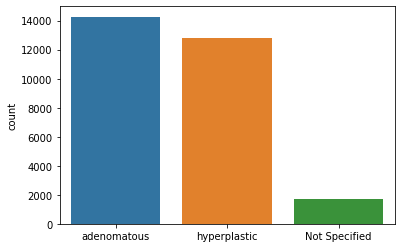

In [16]:
sns.countplot(train_y_polyp_names)

In [17]:
cln_train_X_filepaths, cln_train_y_polyp_names = remove_non_labeled_polyps(
    train_X_filepaths, train_y_polyp_names)

C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

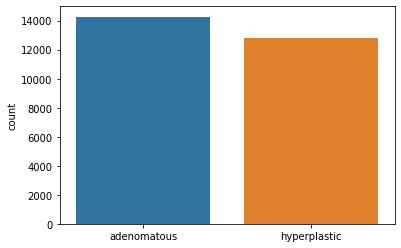

In [18]:
sns.countplot(cln_train_y_polyp_names)

In [19]:
len(cln_train_X_filepaths)

27048

In [20]:
len(cln_train_y_polyp_names)

27048

In [21]:
train_X_images = get_images(cln_train_X_filepaths, 120)

100%|████████████████████████████████████████████████████████████████████████████| 27048/27048 [06:34<00:00, 68.60it/s]


In [22]:
X_train = np.array(train_X_images)

In [23]:
X_train = X_train / 255

In [24]:
label_enc = LabelEncoder()
train_y = label_enc.fit_transform(cln_train_y_polyp_names)
classes = ['adenomatous', 'hyperplastic']

In [25]:
np.save("polyp_y_train_27048.npy", train_y)

In [26]:
np.save("polyp_x_train_27048.npy", X_train)

## Loading Validation Set

In [ ]:
valid_X_basepath = "PolypsSet/val2019/Image"
valid_y_basepath = "PolypsSet/val2019/Annotation"

# Problem is that the valid set has more labels than there are images, so need to make them equal
valid_X_filepaths, valid_X_filenames, valid_y_filepaths, valid_y_filenames= get_filepaths_videonum_dirs_xy(valid_X_basepath, valid_y_basepath)

In [ ]:
valid_y_polyp_names = get_xml_label_names(valid_y_filepaths)

In [ ]:
sns.countplot(valid_y_polyp_names)

In [ ]:
cln_valid_X_filepaths, cln_valid_y_polyp_names = remove_non_labeled_polyps(
    valid_X_filepaths, valid_y_polyp_names)

In [ ]:
sns.countplot(cln_valid_y_polyp_names)

In [ ]:
valid_X_images = get_images(cln_valid_X_filepaths, 120)

In [ ]:
X_valid = np.array(valid_X_images)

In [ ]:
X_valid = X_valid / 255

In [ ]:
valid_y = label_enc.fit_transform(cln_valid_y_polyp_names)

In [ ]:
np.save("polyp_x_valid_4254.npy", X_valid)

In [ ]:
np.save("polyp_y_valid_4254.npy", valid_y)

## Loading Testing Set

In [ ]:
test_X_basepath = "PolypsSet/test2019/Image"
test_y_basepath = "PolypsSet/test2019/Annotation"

# Potential Problem is that the test set has more labels than there are images, so need to make them equal
test_X_filepaths, test_X_filenames, test_y_filepaths, test_y_filenames= get_filepaths_videonum_dirs_xy(test_X_basepath, test_y_basepath)

In [ ]:
test_y_polyp_names = get_xml_label_names(test_y_filepaths)

In [ ]:
sns.countplot(test_y_polyp_names)

In [ ]:
cln_test_X_filepaths, cln_test_y_polyp_names = remove_non_labeled_polyps(
    test_X_filepaths, test_y_polyp_names)

In [ ]:
test_X_images = get_images(cln_test_X_filepaths, 120)

In [ ]:
X_test = np.array(test_X_images)

In [ ]:
X_test = X_test / 255

In [ ]:
sns.countplot(cln_test_y_polyp_names)

In [ ]:
test_y = label_enc.fit_transform(cln_test_y_polyp_names)

In [ ]:
np.save("polyp_y_test_4872.npy", test_y)

In [ ]:
np.save("polyp_x_test_4872.npy", X_test)

## Build UNet

In [32]:
N = X_train.shape[-1]

In [36]:
base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

85532672/85521592 [==============================] - 5s 0us/step


In [37]:
inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

In [40]:
model = Model(inp, out, name=base_model.name)

In [41]:
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

In [44]:
model.fit(
    x=X_train[0:3000],
    y=train_y[0:3000],
    batch_size=16,
    epochs=3,
    validation_split=0.3,
    verbose=True
)

Epoch 1/3


ValueError: in user code:

    File "C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\keras\backend.py", line 3224, in concatenate
        return tf.concat([to_dense(x) for x in tensors], axis)

    ValueError: Exception encountered when calling layer "decoder_stage1_concat" (type Concatenate).
    
    Dimension 1 in both shapes must be equal, but are 16 and 15. Shapes are [?,16,16] and [?,15,15]. for '{{node model_4/model_4/decoder_stage1_concat/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](model_4/model_4/decoder_stage1_upsampling/resize/ResizeNearestNeighbor, model_4/model_4/stage3_unit1_relu1/Relu, model_4/model_4/decoder_stage1_concat/concat/axis)' with input shapes: [?,16,16,256], [?,15,15,128], [] and with computed input tensors: input[2] = <3>.
    
    Call arguments received:
      • inputs=['tf.Tensor(shape=(None, 16, 16, 256), dtype=float32)', 'tf.Tensor(shape=(None, 15, 15, 128), dtype=float32)']
